In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]

## Training (Naive) Bayes

As we have shown in the previous lectures training a Bayes classifier amounts to finding the conditional probability distributions of the features $\mathbf{f}$ given the class label $c$. 

$$P(\mathbf{F}=\mathbf{f}|C=c)$$

In case of the Naive bayes classifier the $n_f$ features are conditionally independent 

$$P(\mathbf{F}=\mathbf{f}|C=c)=\prod_{i=0}^{n_f-1} P(F_i=f_i|C=c)$$

so we can estimate   probality distribution  for each feature separately. 

In case of categorical features each $x_i$ has a finite $m_i$  number of possible values (categories) that, without any loss of generality we can  assume, take values $0,\ldots,m_i-1$. In the same way we  will assume that the class labels take $n_c$ integer values $c=0,\ldots,n_c-1$. 

So for each feature we have  to estimate  $n_c\times m_i$ probabilities 

$$p^{(c)}_{ij} = P(F_i = j|C = c)$$

Of course they are not all idependent. Normalisation requires

$$\sum_{j=0}^{m_i-1} p^{(c)}_{ij}=1,\quad i=0,\ldots,n_f,\; c=0,\ldots,n_c$$

Let $\mathbf{X}$ denote the $n_s \times n_f$ matrix of training data where $n_s$ is the number of samples. So $X_{hi}$ denotes the value of the ith   feature in  sample $h$. Let  $y_h$ denote the corresponding label

$$X_{hi} \in \{0,\ldots,m_i-1\},\quad  y_h \in \{0,\ldots,n_c-1\},\quad h = 0,\ldots,n_s-1$$

Let's introduce some more notation. $n_c$ will denote the number of samples belonging to class $c$

$$n^{c}=\sum_{h=0}^{n_s-1}\delta_{y_h,c},\qquad \delta_{a,b}=
\begin{cases}
1 & a=b\\
0 & a\neq b
\end{cases}$$

and $n^{(c)}_{ij}$ the number of samples of class $c$ with feature $i$ equal to  $j$

$$n^{(c)}_{ij} = \displaystyle
\sum_{h=0}^{n_s-1} \delta_{X_{hi},j}\delta_{y_h,c}
$$

To estimate the probabilities we will use a smoothed estimator 

$$p^{(c)}_{ij} = \frac{n^{(c)}_{ij}+\alpha}{n^c+m_i\alpha} $$

where $\alpha\ge 0$ is a smoothing parameter. The use of  non-zero smoothing parameter ensures a non-vanishing probability even when $n^{(c)}_{ij}=0$. 

## Example: Car evaluation data set

As an example we will use the [car evaluation dataset](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation) from [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/). It contains 1728 samples with six atttributes (features) each. The class label is the evaluation of the car: $\{unacc, acc, good, vgood\}$.

All six parameters are categorical and the data contains exactly one sample for each possible combination of attributes values (in this respect this is quite peculiar dataset).

As before we will use pandas to read and proccess the data.

In [3]:
cars_data = pd.read_csv("../../Data/Cars/car_data.csv", names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])

In [4]:
cars_data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Method `groupby`  divides the data frame into goups based on the value of the given colum(s)

In [6]:
cars_by_class = cars_data.groupby('class')

The size of each group can be calculated using method `size`

In [7]:
cars_by_class.size()

class
acc       384
good       69
unacc    1210
vgood      65
dtype: int64

As we can see the classes are not very well ballanced with relatively small number of cars in two best  classes.  So I have decided to join those two classes together introducing a new classification

In [8]:
def bargain(c):
    if c in ['good', 'vgood']:
        return 'good'
    elif c=='acc':
        return 'fair'
    else:
        return 'bad'

In [9]:
cars_data['bargain'] = cars_data['class'].apply(bargain)
cars_data = cars_data.drop('class',1)

We start by dividing the data set into training and testing. 

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
seed = 678565

In [12]:
cars_train, cars_test = train_test_split(cars_data, train_size=0.75, random_state=seed)

In [13]:
cars_train['bargain'].value_counts()

bad     916
fair    275
good    105
Name: bargain, dtype: int64

In [14]:
cars_test['bargain'].value_counts()

bad     294
fair    109
good     29
Name: bargain, dtype: int64

Function `train_test_split` has an option to _stratify_ data based on the values of one colum

In [15]:
cars_train, cars_test = train_test_split(cars_data, train_size=0.75, stratify=cars_data['bargain'],
                                         random_state = seed)

In this way the split was done separately for each  class label. That way we obtain as a result slightly more balanced sets

In [16]:
cars_train['bargain'].value_counts()

bad     908
fair    288
good    100
Name: bargain, dtype: int64

In [17]:
cars_test['bargain'].value_counts()

bad     302
fair     96
good     34
Name: bargain, dtype: int64

We will use the Naive Bayes.
There are many ways that we can calculate the estimators. We can start by grouping the dataframe according to  feature values

In [18]:
cars_training_grouped = cars_train.groupby(['bargain', 
                                            'buying',
                                            'maint',
                                            'doors', 
                                            'persons', 
                                            'lug_boot',
                                            'safety'])

and count the size of each group

In [19]:
group_counts=cars_training_grouped.size()

The `sum` method can make a partial sums (see Titanic problem) which we can use to extract $n^{c}_{ij}$ values

In [20]:
# The level argument list the levels not summed over i.e. left in the result.
group_counts.sum(level = ['bargain', 'buying'] )

bargain  buying
bad      high      257
         low       186
         med       201
         vhigh     264
fair     high       83
         low        72
         med        83
         vhigh      50
good     low        63
         med        37
dtype: int64

and finally calculate the probabilities

In [21]:
(group_counts.sum(level = ['bargain', 'buying'] ) +1 )/(group_counts.sum(level='bargain')+4)

bargain  buying
bad      high      0.282895
         low       0.205044
         med       0.221491
         vhigh     0.290570
fair     high      0.287671
         low       0.250000
         med       0.287671
         vhigh     0.174658
good     low       0.615385
         med       0.365385
dtype: float64

## Scikit-learn

However if you look closely you will notice one problem: the 'good' class does not contain any values for 'high' and 'vhigh'  attribute values! That means of course that they are zero, but it complicates the calculations. Instead of fixing this by hand we will use the tools from the [scikit-learn](https://scikit-learn.org/stable/index.html) library. This library has a class implementing just what we need

In [22]:
from sklearn.naive_bayes import CategoricalNB

In [23]:
cnb = CategoricalNB(alpha=1)

However this classifier requires the  class labels and attributes to be  integer numbers counted from zero. Fortunatelly scikit-learn also includes a class for converting from labels to ordinals:

In [24]:
from sklearn.preprocessing import  OrdinalEncoder

In [25]:
features_encoder = OrdinalEncoder(dtype='int32')
train_encoded = features_encoder.fit_transform(cars_train)

In [26]:
np.bincount(train_encoded[:,-1])

array([908, 288, 100])

In [27]:
cnb.fit(train_encoded[:,:-1], train_encoded[:,-1])

CategoricalNB(alpha=1)

We can view the learned probabilities of this classifier  using its `feature_log_prob` attribute:

In [28]:
np.exp( cnb.feature_log_prob_[0] )

array([[0.28289474, 0.20504386, 0.22149123, 0.29057018],
       [0.28767123, 0.25      , 0.28767123, 0.17465753],
       [0.00961538, 0.61538462, 0.36538462, 0.00961538]])

Comparing with our calculations we see a almost perfect agreement. Mowever we get all four probabilities in the last line like required. The two values are not zero because of smoothing. 

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(train_encoded[:,-1], cnb.predict(train_encoded[:,0:-1]), normalize=True)

0.8804012345679012

After training the classifier we can use it to  make predictions on the test set

In [30]:
test_encoded = features_encoder.transform(cars_test)
encoded_test_class = test_encoded[:,-1]

In [31]:
predicted_test_class = cnb.predict(test_encoded[:,:-1])

and test them

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(encoded_test_class, predicted_test_class, normalize=True)

0.8888888888888888

Actually the classifier has a method for predicting and measuring accuracy

In [34]:
cnb.score(test_encoded[:,:-1], encoded_test_class)

0.8888888888888888

which unsuprisingly gives same results

As a last check I will look at the class distribution in the predicted and real labels. As it may happen that with unbalanced  classes  one class can be e.g. totaly misclassified without affecting accuracy. 

In [35]:
np.bincount(predicted_test_class.astype('int64'))

array([317,  94,  21])

In [36]:
np.bincount(encoded_test_class.astype('int64'))

array([302,  96,  34])

## Multiclass metrics

The accuracy  generalises intuitively to non-binary classification. Other metrics are defined only for binary classification problem as they rely on the confusion matrix.  A way to generalise them to multiclass classification it to treat a $k$ class classifcation problem as $k$ binary classification problems: class $C_i$ against the rest. We combine the final score out of binary metrics for each binary classification. 

In [37]:
from sklearn.metrics import multilabel_confusion_matrix

In [38]:
pred = predicted_test_class
true = encoded_test_class

In [39]:
def stat(y_true, y_pred, c):
    lbl_true = np.where(y_true==c,1,0)
    lbl_pred = np.where(y_pred==c,1,0)
    TP = np.sum(lbl_true * lbl_pred)
    FP = np.sum( (1-lbl_true)*lbl_pred)
    TN = np.sum((1-lbl_true) * (1-lbl_pred))
    FN = np.sum(lbl_true * (1-lbl_pred))            
    return TP, FP,FN, TN

In [40]:
for i in range(3):
    print( stat(true,pred, i))

(294, 23, 8, 107)
(71, 23, 25, 313)
(19, 2, 15, 396)


Once we have the statistics for each binary classifier we can combine the together. We will consider _micro_ and _macro_ averaging. 

In [41]:
mcf = multilabel_confusion_matrix(true, pred)
print(mcf)

[[[107  23]
  [  8 294]]

 [[313  23]
  [ 25  71]]

 [[396   2]
  [ 15  19]]]


<table style="font-size:1.5em;">
<tr> <th>         </th> <th colspan=2>actual</th></tr>
<tr> <th>predicted</th> <th>N  </th> <th>P  </th></tr>
<tr> <th> N       </th> <td>TN </td> <td>FP </td></tr>
<tr> <th> P       </th> <td>FN </td> <td>TP </td></tr>
<tr> <th>total</th> <td> P</td> <td>N</td></tr>
</table>

### Micro averaging

In micro averaging we first calculate the summary values of TP, FP, TN and TN and use them to calculate the total score. 
We will start with _recall_ which is just another name for true positives rate.

$$Recall_\mu = \frac{\sum_i TP_i}{\sum_i(TP_i+FN_i)}$$

In [42]:
num = 0
den = 0
for i in range(3):
    ((tn, fp), (fn, tp)) =  mcf[i]
    num += tp
    den += tp+fn
recall_mu = num/den    
print(num, den, recall_mu   )

384 432 0.8888888888888888


$$Precision_\mu = \frac{\sum_i TP_i}{\sum_i(TP_i+FP_i)}$$

In [43]:
num = 0
den = 0
for i in range(3):
    ((tn, fp), (fn, tp)) =  mcf[i]
    num += tp
    den += tp+fp
precision_mu = num/den    
print(num, den, precision_mu    )

384 432 0.8888888888888888


and $F_1$ is then  harmonic mean of the two

$$F_\mu = 2\cdot\frac{Precision_\mu\cdot Recall_\mu}{Precision_\mu + Recall_\mu}$$

In [44]:
print(2*precision_mu*recall_mu/(precision_mu+recall_mu))

0.8888888888888888


#### Problem

  Show that $Recall_\mu$ = $Precision_\mu = Accuracy$

There is no surprise that scikit-learn library has functions to calculate those metrics

In [45]:
from sklearn.metrics import *

In [46]:
print(
    recall_score(encoded_test_class, predicted_test_class, average='micro'),
    precision_score(encoded_test_class, predicted_test_class, average='micro'),
    f1_score(encoded_test_class, predicted_test_class, average='micro'))

0.8888888888888888 0.8888888888888888 0.8888888888888888


### Macro averaging

With macro averaging we  calculate  score for each binary classifier separately and average them. So for recall

$$Recall_M = \frac{1}{k}\sum_{i=0}^{k-1}\frac{TP_i}{TP_i+FN_i}$$

In [47]:
tot = 0
for i in range(3):
    ((tn, fp), (fn, tp)) =  mcf[i]
    tot +=tp/(tp+fn)
rec = tot/3    
print(rec)

0.7573055988399776


In [48]:
recall_score(encoded_test_class, predicted_test_class, average='macro')

0.7573055988399776

and for precision

$$Precision_M = \frac{1}{k}\sum_{i=0}^{k-1}\frac{TP_i}{TP_i+FP_i}$$

In [49]:
tot = 0
for i in range(3):
    ((tn, fp), (fn, tp)) =  mcf[i]
    tot +=tp/(tp+fp)
prec =  tot/3   
print(prec)

0.8625086162169188


In [50]:
precision_score(encoded_test_class, predicted_test_class, average='macro')

0.8625086162169188

and $F_1$ score is

$$F_1 = \frac{1}{k}\sum_{i=0}^{k-1}\frac{2\cdot TP_i}{TP_i+FP_i +TP_i +FN_i}$$

In [51]:
tot = 0
for i in range(3):
    ((tn, fp), (fn, tp)) =  mcf[i]
    tot +=2 * tp/(tp+fp+tp+fn)
f =  tot/3   
print(f)

0.7960655788391525


In [52]:
f1_score(encoded_test_class, predicted_test_class, average='macro')

0.7960655788391525

### Weighted averaging 

And finally the weighted averaging is like macro averaging but we  weight the average by the support of each class _i.e._ the number of labels of each class. E.g. for precision

In [53]:
tot = 0
den = 0
for i in range(3):
    tp, fp, fn, tn =  stat(true,pred, i)
    tot +=tp/(tp+fp) *(tp+fn)
    den += (tp+fn)
prec = tot/den
print(prec)

0.8874094239247382


In [54]:
precision_score(encoded_test_class, predicted_test_class, average='weighted')

0.8874094239247382

#### Problem 

 Show that weighted averaging for recall gives same result as micro averaging.

As you may have guessed scikit-learn library has some convenient functions that calculate those metrics at once.

In [55]:
from sklearn.metrics import precision_recall_fscore_support,  classification_report

In [56]:
precision_recall_fscore_support(encoded_test_class, predicted_test_class, beta = 2, average = 'macro')

(0.8625086162169188, 0.7573055988399776, 0.7705692639661881, None)

In [57]:
print(classification_report(encoded_test_class, predicted_test_class))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       302
           1       0.76      0.74      0.75        96
           2       0.90      0.56      0.69        34

    accuracy                           0.89       432
   macro avg       0.86      0.76      0.80       432
weighted avg       0.89      0.89      0.88       432



### Confusion matrix 

In [58]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix , ConfusionMatrixDisplay

In [59]:
cm = confusion_matrix(encoded_test_class, predicted_test_class)
cm

array([[294,   8,   0],
       [ 23,  71,   2],
       [  0,  15,  19]])

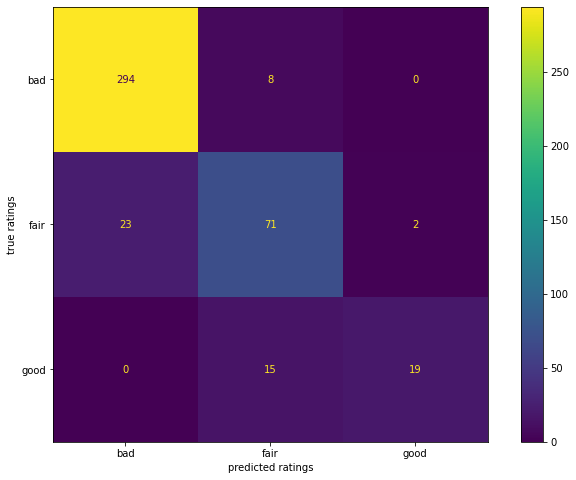

In [60]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['bad', 'fair', 'good'])
fig, ax = plt.subplots(figsize=(12,8))
cm_display.plot(ax=ax);
ax.set_xlabel('predicted ratings')
ax.set_ylabel('true ratings');

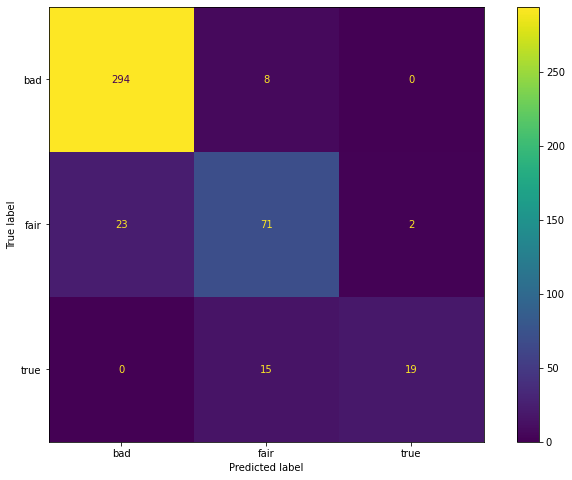

In [61]:
plot_confusion_matrix(cnb, test_encoded[:,:-1], encoded_test_class, display_labels=['bad', 'fair', 'true']);